# Processing Nova project for number of commits and churn
## by Amirreza Shamsolhodaei

In this script, Git repository of the OpenStack Nova Project(located at [here](https://github.com/openstack/nova)) is mined for the number of commits and churn in the top 12 active modules at [nova subdirectory](https://github.com/openstack/nova/tree/master/nova) in the last six months (since 10th of May 2021).
The library that is used for mining informations from the repository is Pydriller (Documentations at [here](https://pydriller.readthedocs.io/en/latest/tutorial.html)) and the library that is used for processing the information is Pandas (Documentations at [here](https://pandas.pydata.org/)).
## Sections:
1. [Importing the required libraries and modules](##Importing-the-required-libraries-and-modules:)
2. [Getting the information from the repostitory](##Getting-the-information-from-the-repostitory)
3. [Processing the information](##Processing-the-information)
4. [Getting the activity indicators for modules in nova](##Getting-the-activity-indicators-for-modules-in-nova)
5. [Identifying and plotting the top 12 actively modified modules](##Identifying-and-plotting-the-top-12-actively-modified-modules)







## 1. Importing the required libraries and modules:
   in this section, the required libraries and modules such as Pydriller and Pandas are imported.

In [1]:
from datetime import datetime
import pydriller
from pydriller.domain.commit import ModifiedFile
import git
from pydriller.metrics.process.commits_count import CommitsCount
from pydriller import Repository
import pandas as pd
import matplotlib.pyplot as plt
import os

%matplotlib inline

## 2. Getting the information from the repostitory
At first, a set of lists are created to hold the information, in the next part, the modules that are needed are filtered.

In [2]:
Hash = []
fileName = []
AddedLines = []
removedLines = []
date = []
churn = []
filePath = []
def directory_split(a):
    if a.count("\\") == 1:
        return a
    return "\\".join(a.split("\\", 2)[:2])

Using Pydriller, the information that is needed is stored at the created lists. Note that in my own testings, I cloned the repository in my own Hard Drive due to the complications with Internet speed. but in the code below, the link to the repository is stated.

In [4]:
for commit in Repository(path_to_repo="https://github.com/openstack/nova",since = datetime(2021, 5, 10)).traverse_commits() :
            for m in commit.modified_files:
                try:
                    path = os.path.dirname(m.new_path)
                    path = directory_split(path)
                except:
                    path = os.path.dirname(m.old_path)
                    path = directory_split(path)
                vchurn = m.added_lines + m.deleted_lines
                Hash.append(commit.hash)
                fileName.append(m.filename)
                AddedLines.append(m.added_lines)
                removedLines.append(m.deleted_lines)
                date.append(commit.committer_date)
                churn.append(vchurn)
                filePath.append(path)


The gathered information is printed out:

In [5]:
setfilename = set(fileName)
setHash = set(Hash)
setfilePath = set(filePath)
print(f"Name of modifications: {len(fileName)}")
print(f"Number of files: {len(setfilename)}")
print(f"Total Added Lines: {sum(AddedLines)}")
print(f"Total Removed Lines: {sum(removedLines)}")
print(f"Total Churns: {sum(churn)}")
print(f"Total Commits: {len(setHash)}")


Name of modifications: 1488
Number of files: 548
Total Added Lines: 36439
Total Removed Lines: 26015
Total Churns: 62454
Total Commits: 289


## 3. Processing the information
Using Pandas, the gathered information is processed and multiple data frames are created to analyze the data.
at the cell below, the first 10 rows of the data frame for all of the modifications is shown.

In [6]:
df = pd.DataFrame(list(zip(date, fileName, filePath, Hash, AddedLines, removedLines, churn)),columns= ['Date', 'File Name', "Module", 'Commits', 'Added Lines', 'Removed Lines', 'Churn'])
df.head(10)

,Date,File Name,Module,Commits,Added Lines,Removed Lines,Churn
0,2021-05-10 15:04:31-04:00,test_utils.py,nova\tests,251e601a4d86b487723b5297abf38b967def3d5e,3,3,6
1,2021-05-10 19:18:30+00:00,__init__.py,nova\tests,8b647f1b3f56879be221b3925570790a1e0e77f8,0,0,0
2,2021-05-10 19:18:30+00:00,test_rbd.py,nova\tests,8b647f1b3f56879be221b3925570790a1e0e77f8,1,1,2
3,2021-05-11 17:28:56+02:00,rbd_utils.py,nova\storage,86af7feed06f08ddb3ef65122089216708d53a06,8,1,9
4,2021-05-11 17:28:56+02:00,test_rbd.py,nova\tests,86af7feed06f08ddb3ef65122089216708d53a06,6,0,6
5,2021-05-12 10:50:52+08:00,common.py,nova\cmd,150b9182512fa0a4f157586e040a7f67c1851005,2,2,4
6,2021-05-12 10:50:52+08:00,neutron.py,nova\network,150b9182512fa0a4f157586e040a7f67c1851005,2,1,3
7,2021-05-12 10:50:52+08:00,test.py,nova,150b9182512fa0a4f157586e040a7f67c1851005,3,3,6
8,2021-05-12 10:50:52+08:00,test_objects.py,nova\tests,150b9182512fa0a4f157586e040a7f67c1851005,3,2,5
9,2021-05-12 10:50:52+08:00,test_imagebackend.py,nova\tests,150b9182512fa0a4f157586e040a7f67c1851005,5,3,8


Using an aggregation function and pandas powerfool tool, Groupby, each file is grouped in an individual row and other columns are treated as described in the cell below, date of the first modification, number of the commits on the file and sum of added lines, removed lines and churn are the output of each column. the first 15 rows of the data frame is shown.

In [7]:
aggregation_functions = {'Date': 'first', 'Commits': 'nunique', 'Added Lines': 'sum', 'Removed Lines': 'sum', 'Churn': 'sum'}
df_name = df.groupby(df['File Name']).aggregate(aggregation_functions)
df_name.head(15)

,Date,Commits,Added Lines,Removed Lines,Churn
File Name,,,,,
.gitignore,2021-10-18 20:26:18+01:00,1,5,1,6
.htaccess,2021-08-17 13:49:18+01:00,2,6,3,9
.pre-commit-config.yaml,2021-11-08 12:37:27+00:00,1,6,0,6
.zuul.yaml,2021-05-26 19:35:29+01:00,10,67,20,87
067_train.py,2021-06-16 10:10:29+01:00,3,318,325,643
068_placeholder.py,2021-08-09 15:34:40+01:00,1,0,0,0
069_placeholder.py,2021-08-09 15:34:40+01:00,1,0,0,0
070_placeholder.py,2021-08-09 15:34:40+01:00,1,0,0,0
071_placeholder.py,2021-08-09 15:34:40+01:00,1,0,0,0


the data frame for files modified is saved as a CSV file for ease of examination.

In [14]:
df_name.to_csv("Changes to each file.csv")

the data frame for every modification is saved as a CSV file for ease of examination.

In [15]:
df.to_csv("List of Modifications.csv")

## 4. Getting the activity indicators for modules in nova
As we only want activity indactors in nova subfolder, the cell below is created.

In [8]:
df = df[df['Module'].str.contains('nova')]
df = df[~df['Module'].str.contains('etc')]
df = df[df.Module != 'nova']

Using another aggregation function and groupby, each module is grouped in an individual row and other columns are treated as described in the cell below, date of the first modification, first file that i modified in the module and and sum of added lines, removed lines and churn are the output of each column. the data frame is shown. 

In [9]:
aggregation_functions = {'Date': 'first','File Name' : 'first', 'Commits': 'nunique', 'Added Lines': 'sum', 'Removed Lines': 'sum', 'Churn': 'sum'}
df_path = df.groupby(df['Module'],as_index=False).aggregate(aggregation_functions)
df_path.head(30)

,Module,Date,File Name,Commits,Added Lines,Removed Lines,Churn
0,nova\accelerator,2021-08-05 15:58:23+08:00,cyborg.py,2,121,25,146
1,nova\api,2021-06-09 22:20:38+00:00,requestlog.py,21,670,373,1043
2,nova\cmd,2021-05-12 10:50:52+08:00,common.py,16,686,267,953
3,nova\compute,2021-06-01 11:29:38-03:00,manager.py,32,550,221,771
4,nova\conductor,2021-06-16 10:10:29+01:00,manager.py,7,130,54,184
5,nova\conf,2021-05-19 10:29:56+02:00,libvirt.py,13,105,216,321
6,nova\console,2021-05-14 17:26:00+02:00,websocketproxy.py,2,24,6,30
7,nova\db,2021-06-16 10:10:27+01:00,migration.py,38,6899,5487,12386
8,nova\hacking,2021-08-09 15:34:40+01:00,checks.py,2,64,2,66
9,nova\network,2021-05-12 10:50:52+08:00,neutron.py,21,437,276,713


The data frame above is saved as an csv file in the cell below:

In [16]:
df_path.to_csv("Nova Modules.csv")

## 5. Identifying and plotting the top 12 actively modified modules
Top 12 modules based on churn is shown in the data frame below

In [10]:
df_churn12 = df_path.sort_values(by=['Churn'], ascending = False).head(12)
df_churn12

,Module,Date,File Name,Commits,Added Lines,Removed Lines,Churn
18,nova\tests,2021-05-10 15:04:31-04:00,test_utils.py,200,20648,13449,34097
7,nova\db,2021-06-16 10:10:27+01:00,migration.py,38,6899,5487,12386
16,nova\scheduler,2021-06-01 15:11:50+01:00,availability_zone_filter.py,14,1114,1133,2247
1,nova\api,2021-06-09 22:20:38+00:00,requestlog.py,21,670,373,1043
11,nova\objects,2021-05-20 16:57:24+01:00,image_meta.py,21,580,449,1029
19,nova\virt,2021-05-26 17:26:05+01:00,config.py,34,478,531,1009
2,nova\cmd,2021-05-12 10:50:52+08:00,common.py,16,686,267,953
3,nova\compute,2021-06-01 11:29:38-03:00,manager.py,32,550,221,771
9,nova\network,2021-05-12 10:50:52+08:00,neutron.py,21,437,276,713
13,nova\policies,2021-06-02 20:27:09-05:00,servers.py,3,212,327,539


Using Pandas and matplotlib, chart for number of churns per modules is demonstrated:

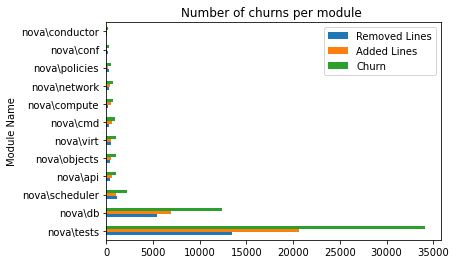

In [11]:
df_churn12[["Module","Removed Lines", "Added Lines", "Churn"]].plot.barh(
    x= 'Module',
    xlabel='Module Name',
    ylabel='Churn',
    title='Number of churns per module '
)

plt.show()

Top 12 modules based on number of commits to each module is shown in the data frame below

In [12]:
df_commit12 = df_path.sort_values(by=['Commits'], ascending = False).head(12)
df_commit12

,Module,Date,File Name,Commits,Added Lines,Removed Lines,Churn
18,nova\tests,2021-05-10 15:04:31-04:00,test_utils.py,200,20648,13449,34097
7,nova\db,2021-06-16 10:10:27+01:00,migration.py,38,6899,5487,12386
19,nova\virt,2021-05-26 17:26:05+01:00,config.py,34,478,531,1009
3,nova\compute,2021-06-01 11:29:38-03:00,manager.py,32,550,221,771
9,nova\network,2021-05-12 10:50:52+08:00,neutron.py,21,437,276,713
1,nova\api,2021-06-09 22:20:38+00:00,requestlog.py,21,670,373,1043
11,nova\objects,2021-05-20 16:57:24+01:00,image_meta.py,21,580,449,1029
2,nova\cmd,2021-05-12 10:50:52+08:00,common.py,16,686,267,953
16,nova\scheduler,2021-06-01 15:11:50+01:00,availability_zone_filter.py,14,1114,1133,2247
5,nova\conf,2021-05-19 10:29:56+02:00,libvirt.py,13,105,216,321


Using Pandas and matplotlib, chart for number of commits per modules is demonstrated:

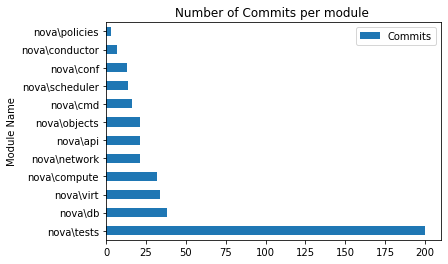

In [13]:
df_commit12[["Module","Commits"]].plot.barh(
    x= 'Module',
    xlabel='Module Name',
    ylabel='Number of Commits',
    title='Number of Commits per module '
)

plt.show()